In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

c:\Users\wndyd\anaconda3\envs\Aicontest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
print(dataset.keys())
print(info)

dict_keys(['train', 'test'])
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\wndyd\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'l

In [3]:
def random_flip(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    return input_image, input_mask
 
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask
 
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
 
    return input_image, input_mask
 
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
 
    return input_image, input_mask

In [4]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [14]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
 
# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [15]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']
 
def display_with_metrics(display_list, iou_list, dice_score_list):
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list))]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True) # sort in place
    display_string_list = [f"{class_names[idx]}: IoU: {iou} Dice Score: {dice_score}" for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)
    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)
 
def display(display_list, titles=[], display_string=None):
    plt.figure(figsize=(15,15))
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
    
    plt.show()
 
def show_image_from_dataset(dataset):
    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=['Image', 'True Maks'])

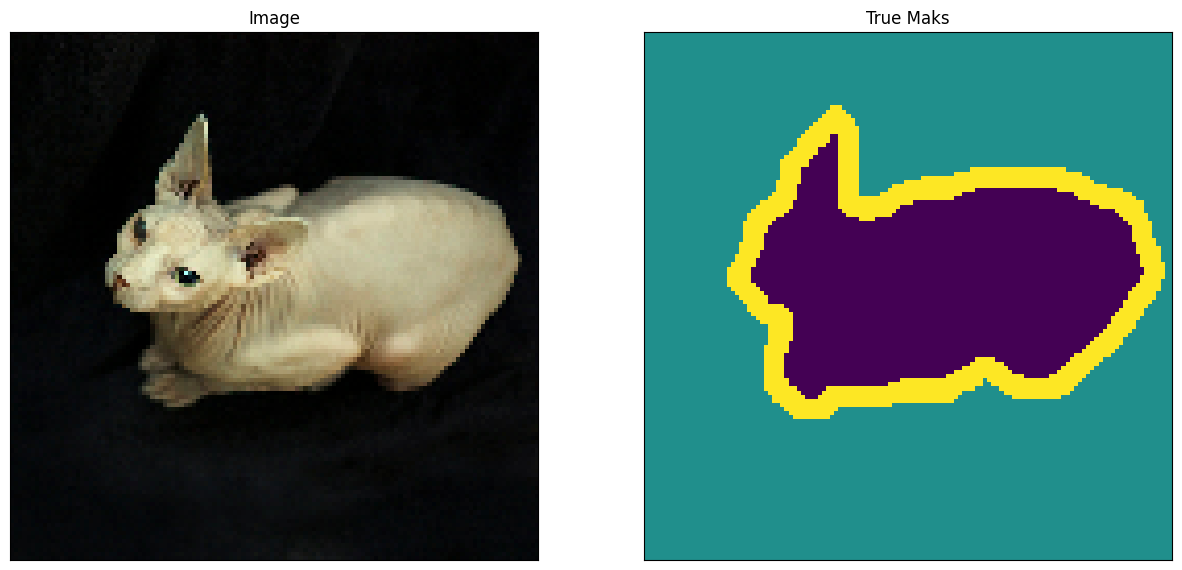

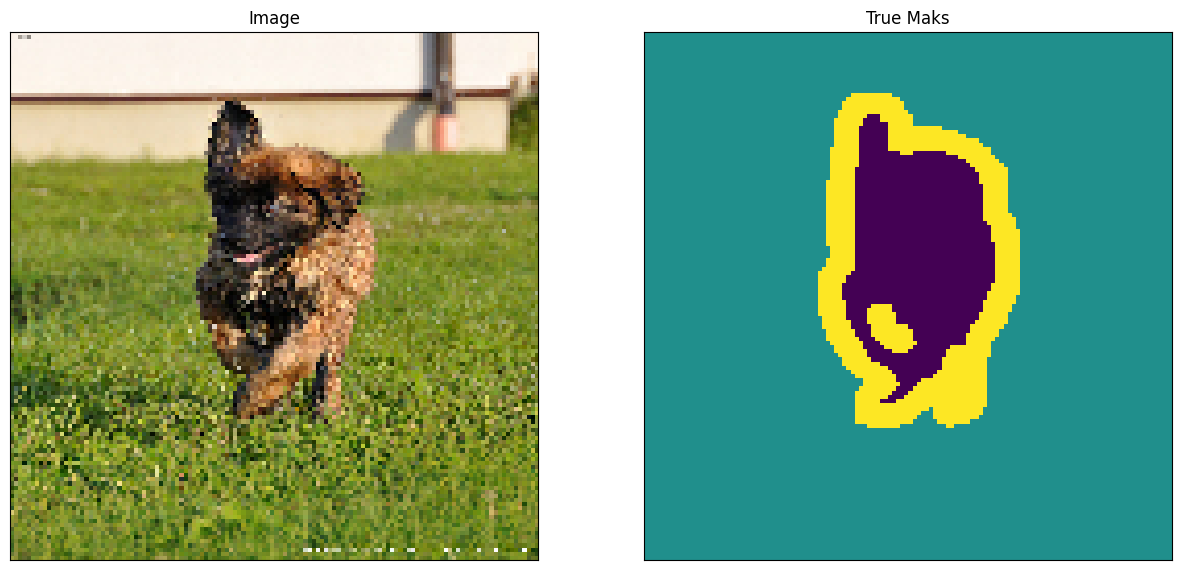

In [16]:
# display an image from the train set
show_image_from_dataset(train)
 
# display an image from the test set
show_image_from_dataset(test)

In [17]:
# Encoder
 
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size,
                                   kernel_initializer='he_normal', activation='relu', padding='same')(x)
    return x
 
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    f = conv2d_block(inputs, n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
 
    return f, p
 
def encoder(inputs):
    f1, p1 = encoder_block(inputs, n_filters=64)
    f2, p2 = encoder_block(p1, n_filters=128)
    f3, p3 = encoder_block(p2, n_filters=256)
    f4, p4 = encoder_block(p3, n_filters=512)
 
    return p4, (f1, f2, f3, f4)

In [18]:
#Bottlnect
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    return bottle_neck

In [19]:
#Decoder
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3) :
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c= conv2d_block(c,n_filters)
    return c

def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4 = convs
 
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=3, strides=2)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=3, strides=2)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=3, strides=2)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=3, strides=2)
 
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(c9)
 
    return outputs

In [20]:
OUTPUT_CHANNELS = 3

def UNet():
    inputs = tf.keras.layers.Input(shape=(128,128,3,))
    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck,convs,OUTPUT_CHANNELS)
    
    model = tf.keras.Model(inputs,outputs)
    return model

model = UNet()
model.summary()   

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_19[0][0]']              
                                )                                                           

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [22]:
# configure the training parameters and train the model
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 20
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
 
# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/20


230/230 [==============================] - 37s 143ms/step - loss: 0.9354 - acc: 0.6462 - val_loss: 0.7113 - val_acc: 0.7176
Epoch 2/20
230/230 [==============================] - 32s 140ms/step - loss: 0.6303 - acc: 0.7451 - val_loss: 0.5810 - val_acc: 0.7679
Epoch 3/20
230/230 [==============================] - 32s 140ms/step - loss: 0.5462 - acc: 0.7855 - val_loss: 0.4901 - val_acc: 0.8084
Epoch 4/20
230/230 [==============================] - 32s 140ms/step - loss: 0.4892 - acc: 0.8110 - val_loss: 0.4416 - val_acc: 0.8287
Epoch 5/20
230/230 [==============================] - 32s 140ms/step - loss: 0.4475 - acc: 0.8284 - val_loss: 0.4268 - val_acc: 0.8316
Epoch 6/20
230/230 [==============================] - 32s 140ms/step - loss: 0.4200 - acc: 0.8385 - val_loss: 0.3985 - val_acc: 0.8490
Epoch 7/20
230/230 [==============================] - 32s 140ms/step - loss: 0.3995 - acc: 0.8467 - val_loss: 0.3778 - val_acc: 0.8563
Epoch 8/20
230/230 [==============================] - 32s 140ms/st

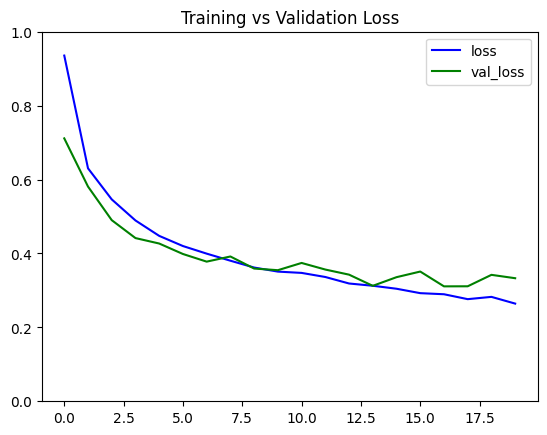

In [24]:
def plot_metrics(model_history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name], 'b', label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], 'g', label='val_'+metric_name)
    plt.legend()
    
plot_metrics(model_history, "loss", title="Training vs Validation Loss", ylim=1)

In [25]:
def get_test_image_and_annotation_arrays():
    ds = test_dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)
    
    images = []
    y_true_segments = []
    
    for image, annotation in ds.take(1) :
        y_true_segments = annotation.numpy()
        images = image.numpy()
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
 
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0].numpy()

def make_predictions(image, mask, num=1):
    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)

    return pred_mask


def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []
 
    smoothening_factor = 0.00001
    
    for i in range(3):
        intersection = np.sum((y_pred==i) * (y_true==i))
        y_true_area = np.sum((y_true==i))
        y_pred_area = np.sum((y_pred==i))
        combined_area = y_true_area + y_pred_area
 
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
 
        dice_score = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
    
    return class_wise_iou, class_wise_dice_score

In [26]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
 
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]
 
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

229/229 [==============================] - 8s 36ms/step


1/1 [==============================] - 1s 958ms/step


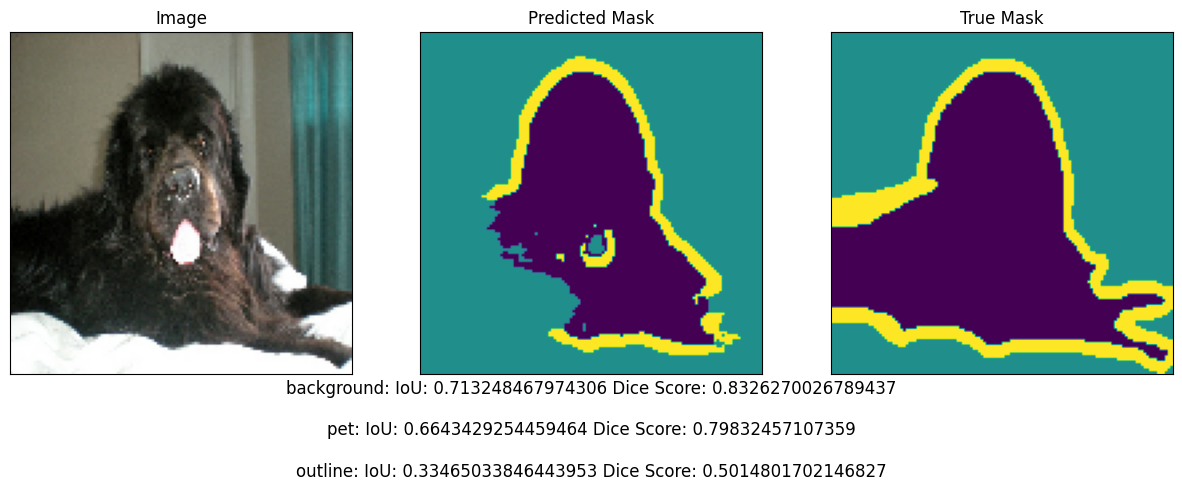

In [27]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 2800
 
# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
 
# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  
 
# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)